<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
import missingno  # for visualizing missing data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature

# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

In [2]:
data = pd.read_csv('data_raw/LoanStats3c_securev1.csv', 
                   header=1, low_memory=False)

data['default'] = data.loan_status.map({'Fully Paid': 0, 'Charged Off': 1})
# Drop loans with indeterminate status
data = data.loc[data.default.notnull(),:]

# Find columns with 0 or 1 unique values
constant_or_missing = [col for col in all_data.columns 
                           if all_data.loc[:,col] \
                                   .value_counts() \
                                   .shape[0] \
                                <= 1] 
print('Columns to be deleted:\n{}'.format(constant_or_missing))
# Delete those columns
all_data = all_data.drop(constant_or_missing, axis=1)

In [3]:
# Delete endogenous and irrelevant variables
endogenous = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
              'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
              'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 
              'debt_settlement_flag', 'int_rate', 'grade', 'sub_grade',
              'last_fico_range_low', 'last_fico_range_high', 'last_credit_pull_d']
irrelevant = ['url', 'initial_list_status', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv']

data = data.drop(['loan_status'] + endogenous + irrelevant, axis='columns')

In [4]:
# Find categorical variables with more than a given proportion of unique values and drop them
unique_values_cat = data.select_dtypes(include='object') \
                        .nunique() \
                        .sort_values(ascending=False) 
print('Dropped Variables: ', unique_values_cat[unique_values_cat >100])
# Drop variables
data = data.drop(unique_values_cat[unique_values_cat > 50].index,
    axis='columns')

X = data.drop('default', axis='columns')
y = data.default    

Dropped Variables:  id                  214527
emp_title            69574
desc                 13977
title                 1957
revol_util            1151
zip_code               864
earliest_cr_line       636
dtype: int64


In [15]:
# Train-test split (for now only select 1% for training)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     # train_size=0.8,
                     train_size=50000, test_size=50000,
                     random_state=1,
                     shuffle=True, stratify=data.default) 

In [6]:
# Imputation and standardization for numeric features
numeric_features = X_train.select_dtypes(include=[np.number]).columns
numeric_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]) 

# Imputation and one-hot encoding for categorical features
categorical_features = X_train.select_dtypes(include=[object]).columns
categorical_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combining preprocessing for both kinds of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough', n_jobs=1)

# Apply preprocessing
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, 
        oob_score=True, n_jobs=3, random_state=1,
        class_weight='balanced_subsample')
rf.fit(X_train_p, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=3, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [8]:
def plot_confusion_matrix(y_test, y_pred, digits=3):
    cf = pd.DataFrame(confusion_matrix(y_test, y_pred,
                                      labels=[1,0]),
                      columns=['True', 'False'])
    cf.index=['True', 'False']
    cf.columns.name = 'Predicted'
    cf.index.name = 'Actual'
    print(round(cf / len(y_test), digits))    
# Plot confusion matrix for random forests
y_pred_rf = rf.predict(X_test_p)
plot_confusion_matrix(y_test, y_pred_rf)

Predicted   True  False
Actual                 
True       0.021  0.165
False      0.003  0.811


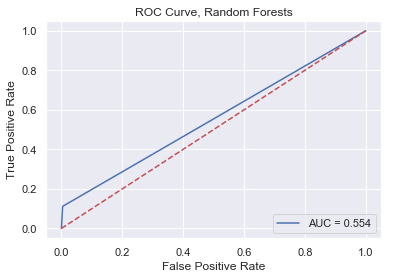

In [9]:
def plot_roc(y_test, y_pred, model_name=None):
    false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_pred_rf)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = {0:.3f}'.format(roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1],[0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title='ROC Curve'
    # Add custom title, if specified
    if model_name is not None:
        title = ', '.join([title, model_name])
    plt.title(title)
    plt.show();
# Plot ROC curve for random forests
plot_roc(y_test, y_pred_rf, 'Random Forests')

In [10]:
f1_score(y_test, y_pred_rf)

0.19771210676835083

In [11]:
# Get a list of feature names
cat_names = preprocessor.named_transformers_['cat'] \
                .named_steps['onehot'].get_feature_names()
feature_names = list(numeric_features) + list(cat_names)

In [12]:
len(feature_names)

328

In [13]:
rf.feature_importances_.shape

(297,)

In [14]:
# Compute feature importance and sort
feature_importances = pd.Series(
                            rf.feature_importances_,
                            index=feature_names) \
                        .sort_values(ascending=False)
feature_importances

ValueError: Length of passed values is 297, index implies 328

In [ ]:
# Learning curve
ns = [1000, 10000, 100000, 200000]
f1_scores = {}
for n in ns:
    X_train_p_subset, y_train_subset = resample(
        X_train_p, y_train, replace=False, n_samples=n, random_state=1)
    rf_subset = RandomForestClassifier(
        n_estimators=100, n_jobs=3, random_state=1,
        class_weight='balanced_subsample')
    rf_subset.fit(X_train_p_subset, y_train_subset)
    y_pred_rf_subset = rf_subset.predict(X_test_p)
    f1_scores[n] = f1_score(y_test, y_pred_rf_subset)

plt.plot(pd.Series(f1_scores))
plt.title('Learning Curve')
plt.xlabel('Number of Observations')
plt.ylabel('F1-score')